Memproses folder bensin asli: d:\kuliah\semester 5\Citra Digital\bensin_murni_crop
Memproses folder bensin oplos: d:\kuliah\semester 5\Citra Digital\bensin_oplos_crop

=== Nilai Fitur Bensin Asli ===
Gambar 0: 0.7304887349259042
Gambar 1: 0.7312306788653236
Gambar 2: 0.7315917071148135
Gambar 3: 0.7312240170061405
Gambar 4: 0.7315953916858966
Gambar 5: 0.7312241061442775
Gambar 6: 0.7315915914390884
Gambar 7: 0.7312238922721622
Gambar 8: 0.7312272371878432
Gambar 9: 0.731226064601386

=== Nilai Fitur Bensin Oplos ===
Gambar 0: 0.7326498650890046
Gambar 1: 0.733381405075192
Gambar 2: 0.7322753863104942
Gambar 3: 0.7337466608056551
Gambar 4: 0.7322766674574629
Gambar 5: 0.7337458612607315
Gambar 6: 0.7330124069034292
Gambar 7: 0.7330132808059638
Gambar 8: 0.7337473694678883
Gambar 9: 0.7330130415253152


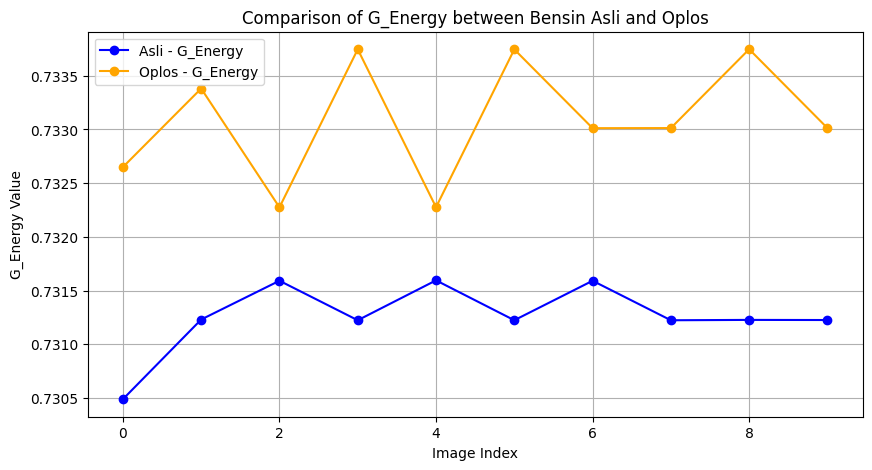

In [22]:
import cv2
import numpy as np
import os
from skimage.feature import local_binary_pattern
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
from glob import glob

# Fungsi untuk menghitung fitur statistik dari histogram
def calculate_color_features(channel_hist):
    features = {}
    
    # Normalisasi histogram
    channel_hist = channel_hist / np.sum(channel_hist)
    
    # Mean
    features['Mean'] = np.mean(channel_hist)
    
    # Variance (Varian)
    features['Variance'] = np.var(channel_hist)
    
    # Skewness (Kemiringan)
    features['Skewness'] = skew(channel_hist)
    
    # Kurtosis
    features['Kurtosis'] = kurtosis(channel_hist)
    
    # Energi
    features['Energy'] = np.sum(channel_hist ** 2)
    
    # Entropi
    features['Entropy'] = -np.sum(channel_hist * np.log2(channel_hist + 1e-10))  # Menghindari log(0)
    
    return features

# Fungsi untuk menghitung fitur dari histogram LBP
def calculate_lbp_features(hist_lbp):
    features = {}
    
    # Normalisasi histogram
    hist_lbp = hist_lbp / np.sum(hist_lbp)
    
    # Mean
    features['Mean'] = np.mean(hist_lbp)
    
    # Variance (Varian)
    features['Variance'] = np.var(hist_lbp)
    
    # Skewness (Kemiringan)
    features['Skewness'] = skew(hist_lbp)
    
    # Kurtosis
    features['Kurtosis'] = kurtosis(hist_lbp)
    
    # Energi
    features['Energy'] = np.sum(hist_lbp ** 2)
    
    # Entropi
    features['Entropy'] = -np.sum(hist_lbp * np.log2(hist_lbp + 1e-10))  # Menghindari log(0)
    
    return features

# Fungsi untuk mengolah citra dengan LBP dan mengekstrak fitur dari channel RGB
def process_image_with_lbp_and_rgb(image_path):
    # Baca citra
    image = cv2.imread(image_path)
    
    # Ekstraksi fitur dari channel RGB
    color_features = {}
    for i, color in enumerate(['R', 'G', 'B']):
        channel = image[:, :, i]
        hist_channel, _ = np.histogram(channel.ravel(), bins=256, range=(0, 256))
        channel_features = calculate_color_features(hist_channel)
        color_features.update({f"{color}_{k}": v for k, v in channel_features.items()})
    
    # Konversi ke grayscale untuk LBP
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Parameter LBP
    radius = 1
    n_points = 8 * radius  # Jumlah titik sampel di sekitar piksel pusat
    
    # Ekstraksi LBP
    lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform')
    
    # Hitung histogram LBP
    hist_lbp, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    
    # Normalisasi histogram
    hist_lbp = hist_lbp.astype('float')
    hist_lbp /= (hist_lbp.sum() + 1e-6)
    
    # Ekstraksi fitur dari histogram LBP
    lbp_features = calculate_lbp_features(hist_lbp)
    
    # Gabungkan fitur LBP dan RGB
    all_features = {**lbp_features, **color_features}
    
    return all_features

# Fungsi untuk memproses semua gambar di dalam folder
def process_folder(folder_path):
    features_list = []
    
    # Ambil semua file gambar .png di folder
    image_paths = glob(os.path.join(folder_path, '*.png'))
    
    # Proses setiap gambar
    for image_path in image_paths:
        features = process_image_with_lbp_and_rgb(image_path)
        features_list.append(features)
    
    return features_list

# Fungsi untuk membandingkan fitur dari dua folder
def compare_folders(folder1, folder2, feature_name):
    # Proses folder bensin asli
    print(f"Memproses folder bensin asli: {folder1}")
    features_bensin_asli = process_folder(folder1)
    
    # Proses folder bensin oplos
    print(f"Memproses folder bensin oplos: {folder2}")
    features_bensin_oplos = process_folder(folder2)
    
    # Ekstrak fitur yang diinginkan untuk kedua folder
    feature_asli = [f[feature_name] for f in features_bensin_asli]
    feature_oplos = [f[feature_name] for f in features_bensin_oplos]
    
    # Cetak nilai numerik untuk setiap gambar
    print("\n=== Nilai Fitur Bensin Asli ===")
    for idx, val in enumerate(feature_asli):
        print(f"Gambar {idx}: {val}")
    
    print("\n=== Nilai Fitur Bensin Oplos ===")
    for idx, val in enumerate(feature_oplos):
        print(f"Gambar {idx}: {val}")
    
    # Plot perbandingan fitur
    plt.figure(figsize=(10, 5))
    plt.plot(feature_asli, label=f"Asli - {feature_name}", marker='o', color='b')
    plt.plot(feature_oplos, label=f"Oplos - {feature_name}", marker='o', color='orange')
    
    plt.title(f"Comparison of {feature_name} between Bensin Asli and Oplos")
    plt.xlabel('Image Index')
    plt.ylabel(f'{feature_name} Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Folder path sesuai dengan lokasi gambar bensin asli dan bensin oplos
folder_bensin_asli = r'd:\kuliah\semester 5\Citra Digital\bensin_murni_crop'
folder_bensin_oplos = r'd:\kuliah\semester 5\Citra Digital\bensin_oplos_crop'

# Pilih fitur yang ingin dibandingkan, misalnya 'R_Mean', 'R_Skewness', 'B_Variance', atau lainnya
compare_folders(folder_bensin_asli, folder_bensin_oplos, 'G_Energy')


Hasil ekstraksi fitur CoALBP:
                                           image_path  Red_contrast  \
0   d:\kuliah\semester 5\Citra Digital\bensin_murn...      2.045546   
1   d:\kuliah\semester 5\Citra Digital\bensin_murn...      2.021653   
2   d:\kuliah\semester 5\Citra Digital\bensin_murn...      2.026739   
3   d:\kuliah\semester 5\Citra Digital\bensin_murn...      2.033416   
4   d:\kuliah\semester 5\Citra Digital\bensin_murn...      2.037549   
5   d:\kuliah\semester 5\Citra Digital\bensin_murn...      2.038283   
6   d:\kuliah\semester 5\Citra Digital\bensin_murn...      2.037935   
7   d:\kuliah\semester 5\Citra Digital\bensin_murn...      2.021287   
8   d:\kuliah\semester 5\Citra Digital\bensin_murn...      2.041671   
9   d:\kuliah\semester 5\Citra Digital\bensin_murn...      2.035786   
10  d:\kuliah\semester 5\Citra Digital\bensin_oplo...      2.065311   
11  d:\kuliah\semester 5\Citra Digital\bensin_oplo...      2.063504   
12  d:\kuliah\semester 5\Citra Digital\bensin_o

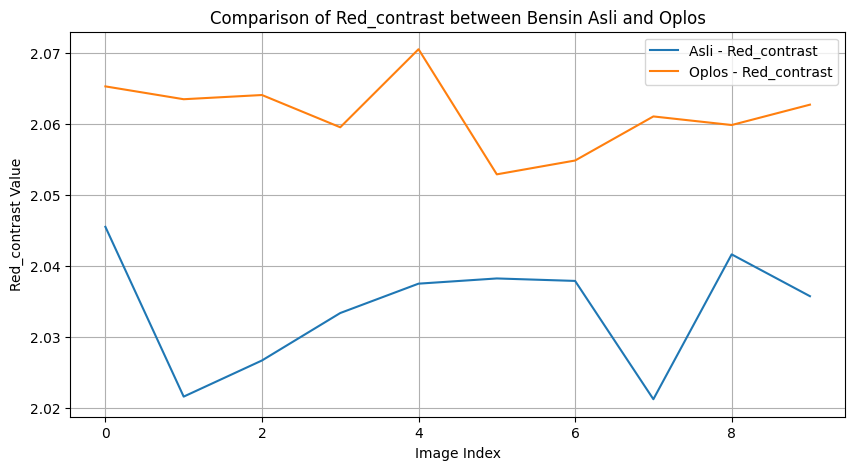

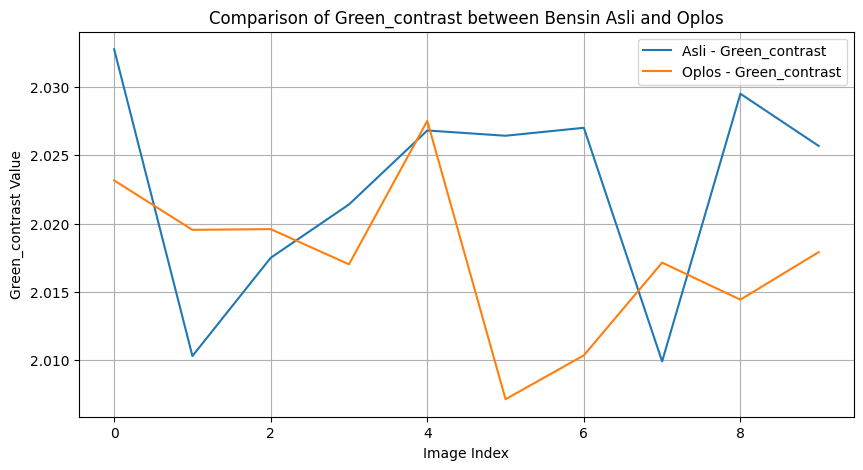

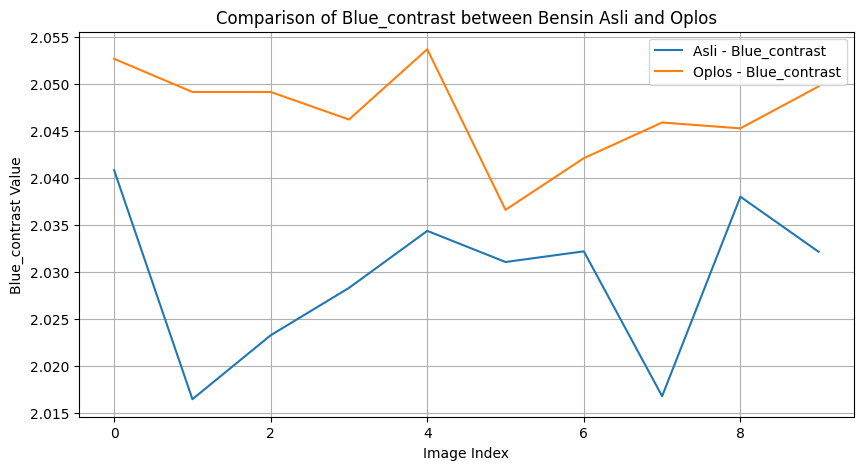

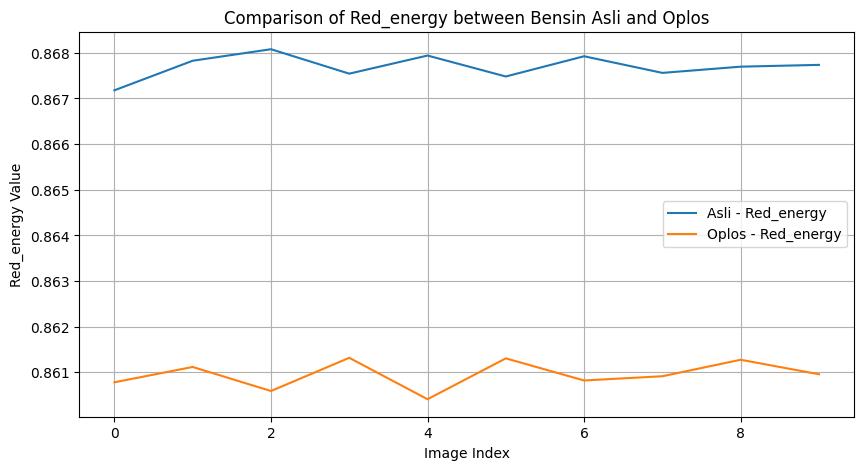

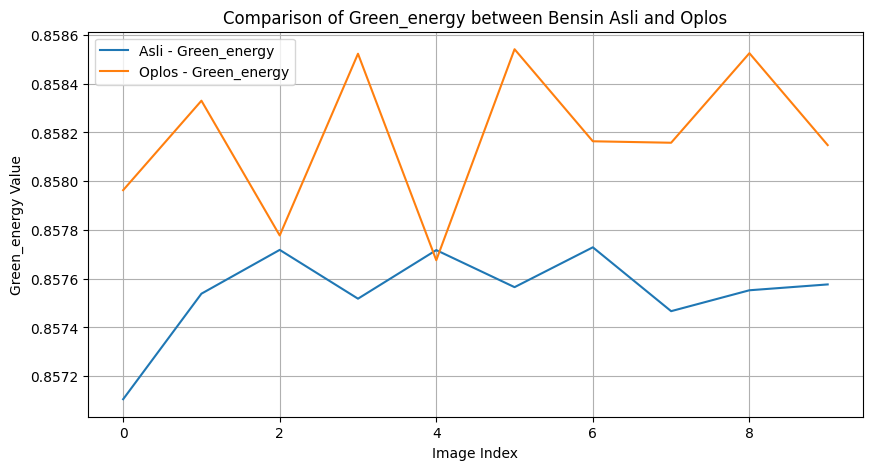

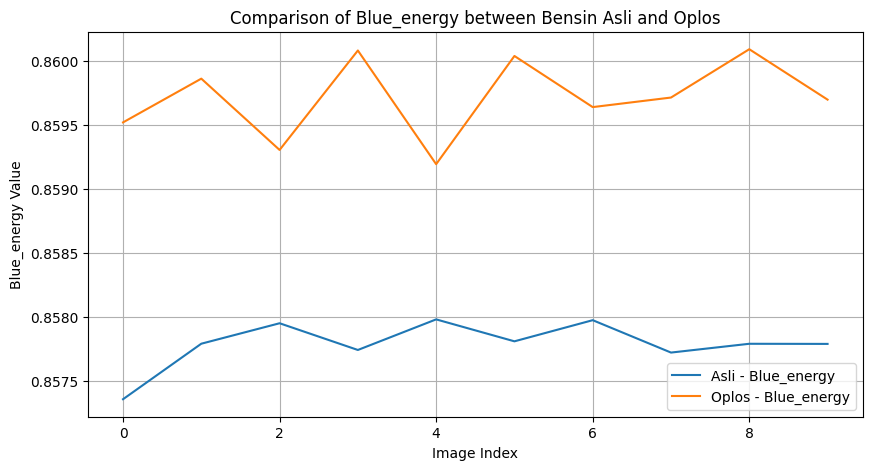

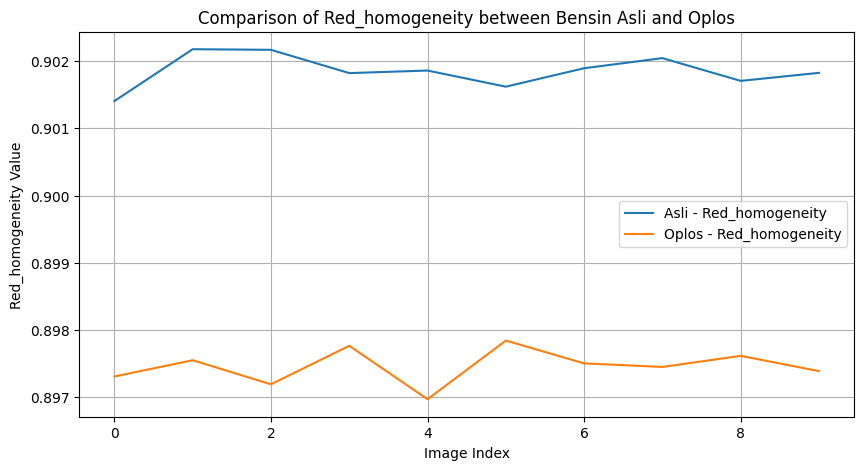

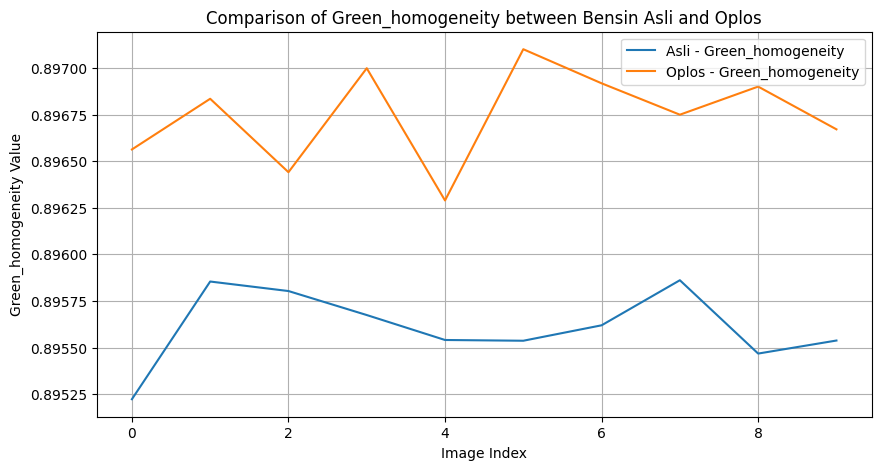

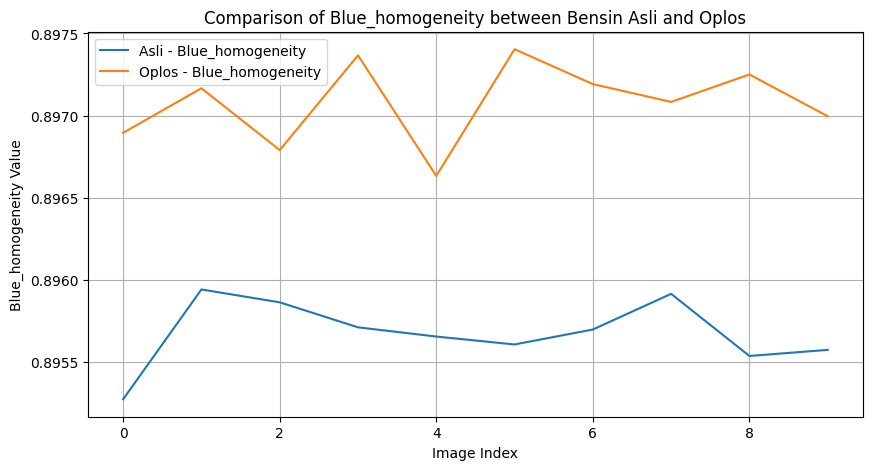


Rata-rata nilai fitur per jenis bensin (Asli vs Oplos):
       Blue_contrast  Blue_correlation  Blue_dissimilarity  Blue_energy  \
type                                                                      
Asli        2.029323          0.451363            0.434978     0.857789   
Oplos       2.047061          0.447391            0.433756     0.859716   

       Blue_homogeneity  Green_contrast  Green_correlation  \
type                                                         
Asli           0.895678        2.022732           0.453175   
Oplos          0.897078        2.017378           0.458903   

       Green_dissimilarity  Green_energy  Green_homogeneity  Red_contrast  \
type                                                                        
Asli              0.434370      0.857549           0.895612      2.033987   
Oplos             0.431264      0.858181           0.896746      2.061451   

       Red_correlation  Red_dissimilarity  Red_energy  Red_homogeneity  
type       

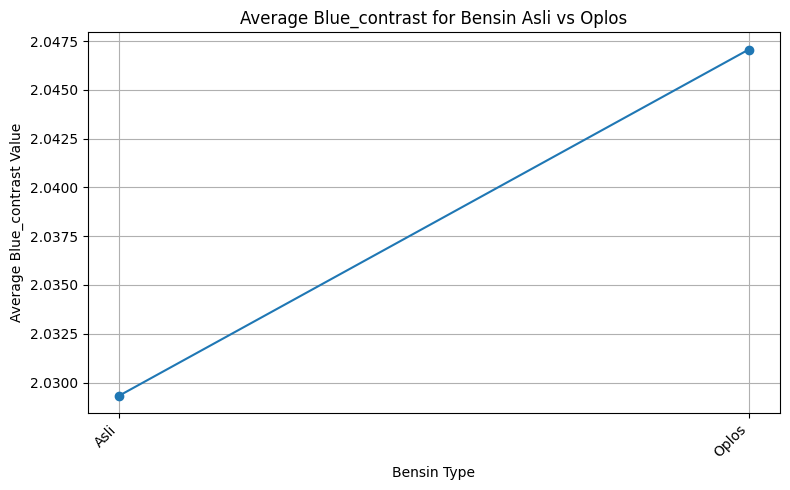

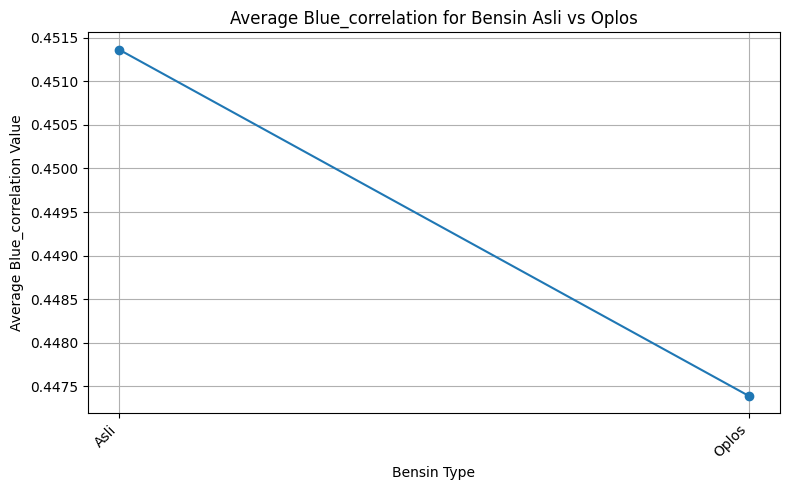

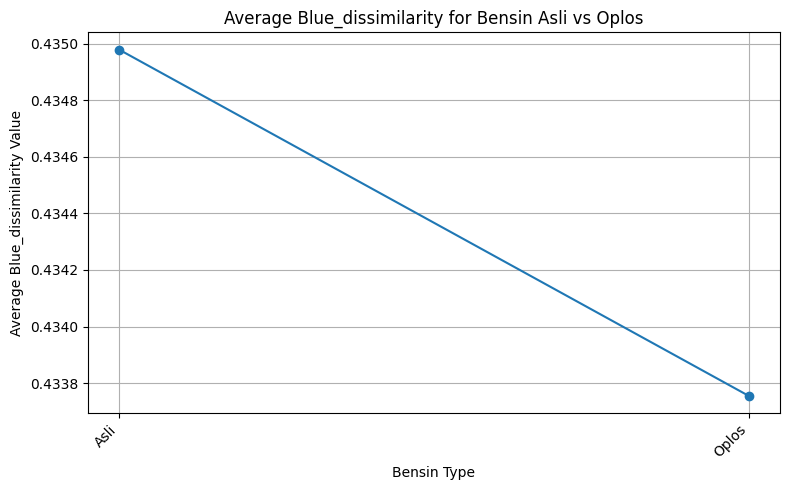

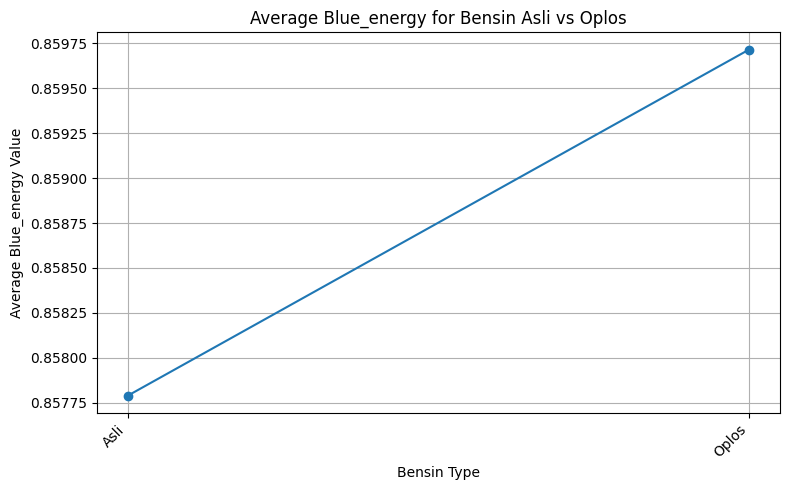

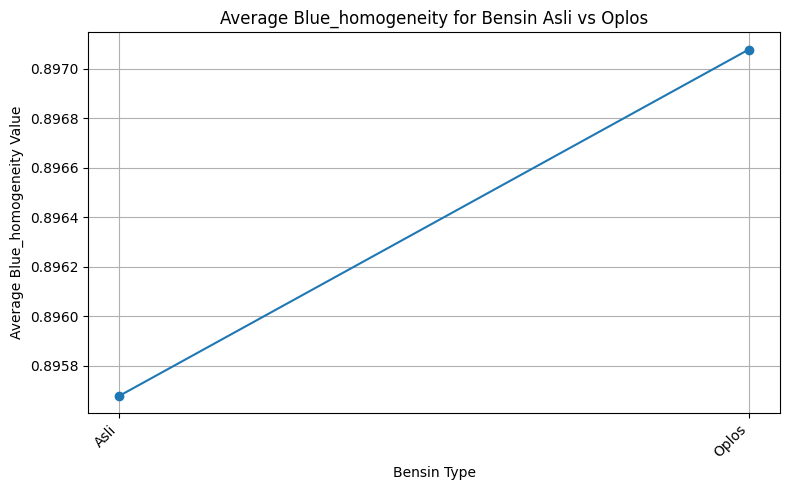

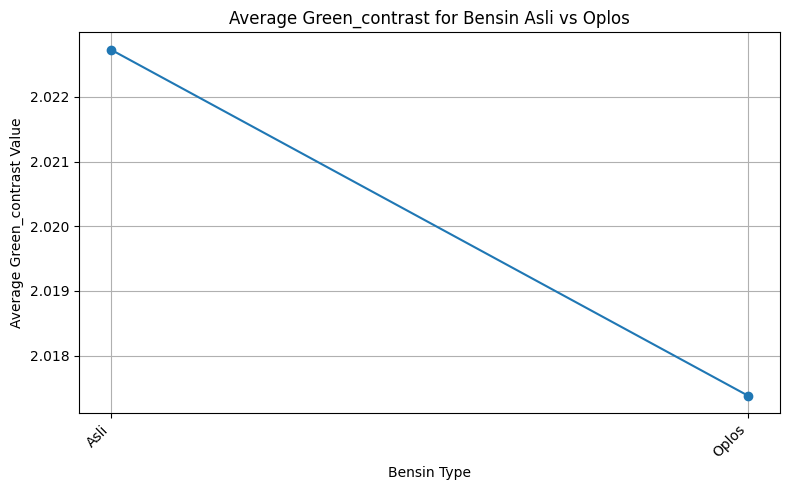

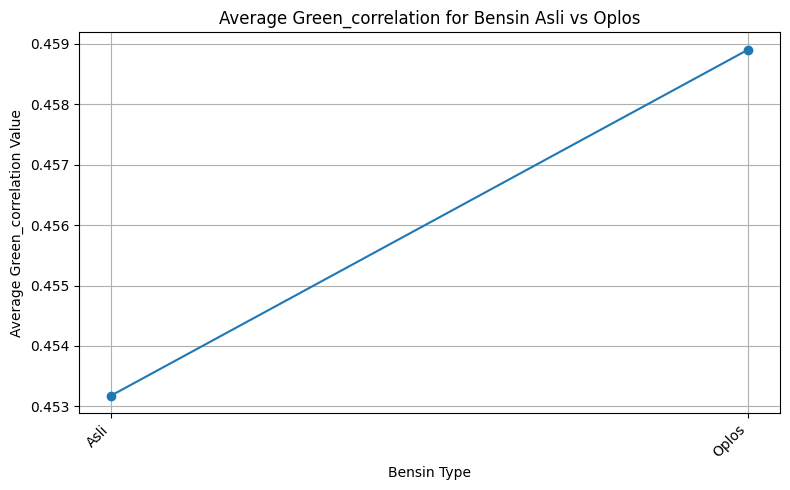

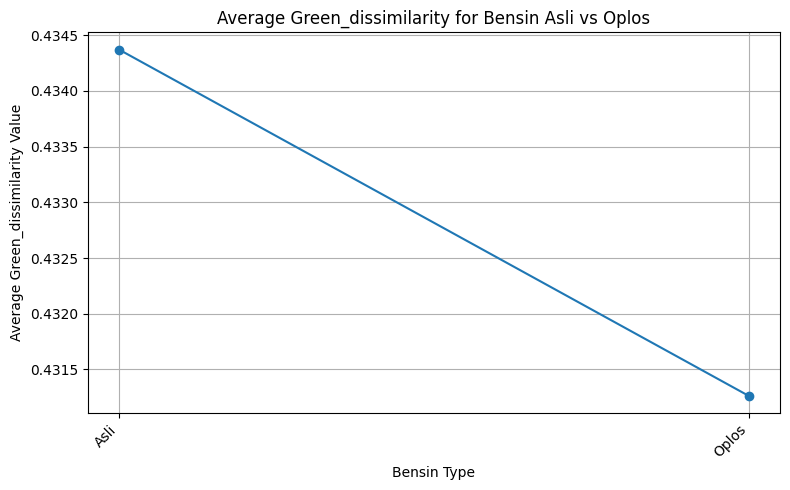

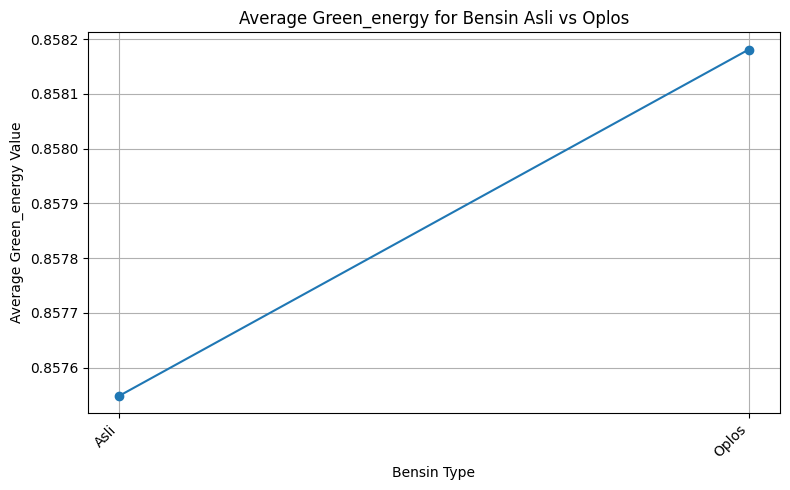

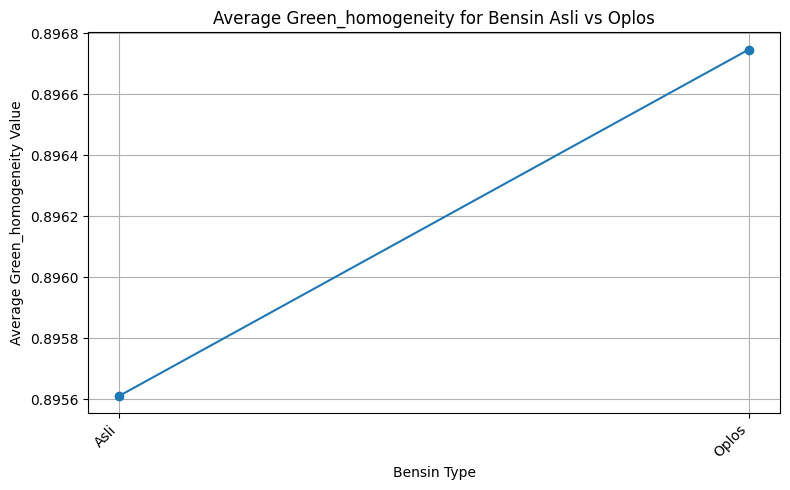

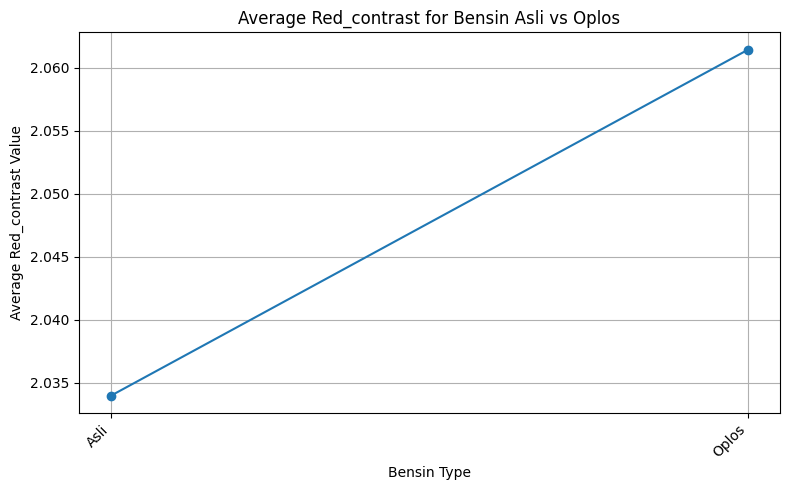

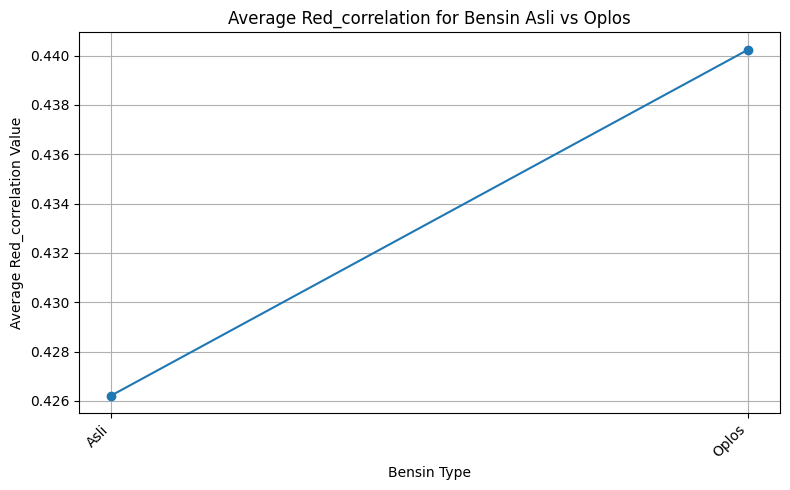

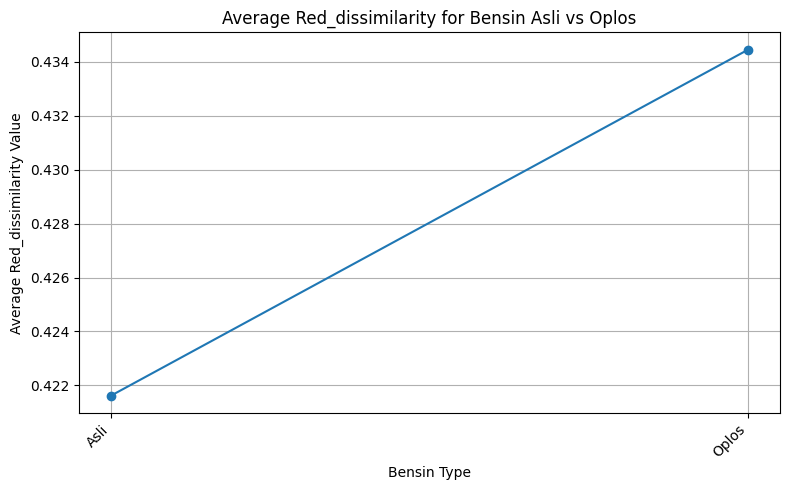

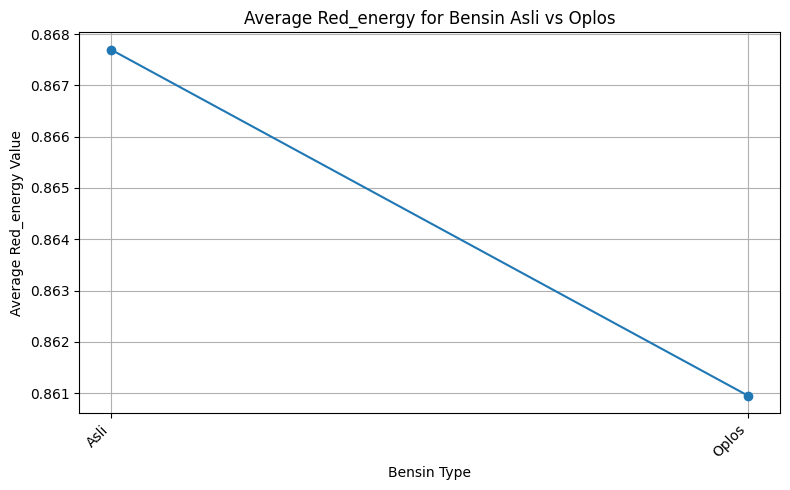

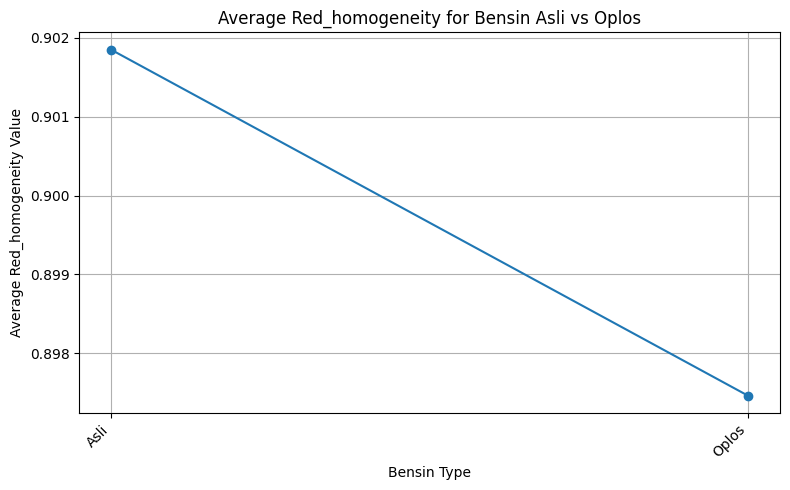

In [18]:
import os
import numpy as np
import cv2
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from skimage import io
import glob
import pandas as pd
import matplotlib.pyplot as plt

# Fungsi untuk menghitung LBP
def compute_lbp(image, radius=1, points=8):
    lbp = local_binary_pattern(image, points, radius, method='uniform')
    return lbp

# Fungsi untuk menghitung CoALBP
def compute_coalbp(image):
    lbp = compute_lbp(image)
    
    # Menghitung CoALBP untuk 4 arah
    directions = [(0, 1), (1, 0), (1, 1), (-1, 1)]
    co_matrix_list = []
    
    for direction in directions:
        angle = np.arctan2(direction[1], direction[0])
        co_matrix = graycomatrix(lbp.astype(np.uint8), distances=[1], angles=[angle], symmetric=True, normed=True)
        co_matrix_list.append(co_matrix)
    
    # Menghitung fitur CoALBP dari semua arah
    features = {}
    for co_matrix in co_matrix_list:
        features['contrast'] = graycoprops(co_matrix, 'contrast')[0, 0]
        features['dissimilarity'] = graycoprops(co_matrix, 'dissimilarity')[0, 0]
        features['homogeneity'] = graycoprops(co_matrix, 'homogeneity')[0, 0]
        features['energy'] = graycoprops(co_matrix, 'energy')[0, 0]
        features['correlation'] = graycoprops(co_matrix, 'correlation')[0, 0]

    return features

# Fungsi untuk mengekstrak fitur dari semua gambar dalam folder
def extract_features_from_folder(folder_path):
    features_list = []
    image_paths = glob.glob(os.path.join(folder_path, "*.png"))  # Menyaring file PNG

    for image_path in image_paths:
        # Membaca citra
        image = io.imread(image_path)

        # Pisahkan channel RGB dan gabungkan hasilnya menjadi satu entri
        features = {}
        channels = {'Red': image[:, :, 0], 'Green': image[:, :, 1], 'Blue': image[:, :, 2]}
        
        # Menghitung fitur untuk setiap channel
        for color, channel in channels.items():
            channel_features = compute_coalbp(channel)
            # Tambahkan fitur CoALBP dari setiap channel dengan nama berbeda
            for key, value in channel_features.items():
                features[f"{color}_{key}"] = value

        # Tambahkan path dan fitur ke daftar
        features_list.append({
            'image_path': image_path,
            **features
        })

    return pd.DataFrame(features_list)

# Mengatur path untuk folder bensin asli dan bensin oplos
folder_bensin_asli = r'd:\kuliah\semester 5\Citra Digital\bensin_murni_crop'  # Ganti dengan path yang sesuai
folder_bensin_oplos = r'd:\kuliah\semester 5\Citra Digital\bensin_oplos_crop'  # Ganti dengan path yang sesuai

# Mengekstrak fitur dari kedua folder
df_bensin_asli = extract_features_from_folder(folder_bensin_asli).assign(type='Asli')
df_bensin_oplos = extract_features_from_folder(folder_bensin_oplos).assign(type='Oplos')

# Menggabungkan hasil dari kedua folder
df_combined = pd.concat([df_bensin_asli, df_bensin_oplos], ignore_index=True)

# Menampilkan hasil
print("Hasil ekstraksi fitur CoALBP:")
print(df_combined)

# Menambahkan perhitungan rata-rata untuk setiap fitur per channel
def compute_feature_averages(df):
    # Memilih kolom fitur (semua kecuali 'image_path' dan 'type')
    feature_columns = df.columns.difference(['image_path', 'type'])
    
    # Menghitung rata-rata untuk masing-masing bensin (Asli dan Oplos)
    averages = df.groupby('type')[feature_columns].mean()
    
    print("\nRata-rata nilai fitur per jenis bensin (Asli vs Oplos):")
    print(averages)
    
    return averages

# Visualisasi perbandingan menggunakan plot
def visualize_features(df_combined):
    # Fitur yang ingin divisualisasikan
    features_to_plot = ['Red_contrast', 'Green_contrast', 'Blue_contrast', 
                        'Red_energy', 'Green_energy', 'Blue_energy', 
                        'Red_homogeneity', 'Green_homogeneity', 'Blue_homogeneity']

    for feature in features_to_plot:
        plt.figure(figsize=(10, 5))
        
        # Membuat plot garis untuk masing-masing jenis bensin
        for label, group_df in df_combined.groupby('type'):
            plt.plot(group_df[feature].values, label=f"{label} - {feature}")
        
        # Memberikan label dan judul
        plt.title(f'Comparison of {feature} between Bensin Asli and Oplos')
        plt.xlabel('Image Index')
        plt.ylabel(f'{feature} Value')
        plt.legend()
        plt.grid(True)
        plt.show()

# Visualisasi rata-rata fitur menggunakan plot untuk setiap fitur
def visualize_feature_averages(averages):
    features = averages.columns
    
    for feature in features:
        plt.figure(figsize=(8, 5))
        plt.plot(averages.index, averages[feature], marker='o')
        
        # Judul dan label sumbu
        plt.title(f'Average {feature} for Bensin Asli vs Oplos')
        plt.xlabel('Bensin Type')
        plt.ylabel(f'Average {feature} Value')
        plt.xticks(rotation=45, ha="right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Memvisualisasikan perbedaan antara bensin asli dan oplos
visualize_features(df_combined)

# Menampilkan rata-rata dari setiap fitur dan visualisasi plot
averages = compute_feature_averages(df_combined)
visualize_feature_averages(averages)
